<a href="https://colab.research.google.com/github/SamLutz/2024_MLEES/blob/main/Labs/09_generativeai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## (Exercise) Introduction to Uncertainty Quantification and Generative Modeling

<center>
<img src="https://github.com/msgomez06/ML_pedagogical_materials/blob/main/images/09.01-missing.png?raw=True" width=90%></img>

We're often tasked with filling voids and to express how sure we are of our answer.
<br> <i> How can we train an algorithm to do the same? </i>
</center>

In [ ]:
#@title ### Prerequisite Imports
#@markdown Run this cell for preliminary requirements. Double click it if you want to check out the source :)

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import pandas as pd
import os

# To make this notebook's output stable across runs
rnd_seed = 42
rnd_gen = np.random.default_rng(rnd_seed)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Import pooch - used to handle data downloading
import pooch

# Define colorblind safe colors for plotting
colors = [np.array([215, 166, 122])/255, np.array([0, 148, 199])/255, np.array([214, 7, 114])/255]

### A Quick Introduction to Uncertainty

Uncertainty is one of those terms that you are likely very familiar with, whether in the colloquial sense (I'd have a hard time believing that any of us have *never* had a moment of doubt) or the scientific sense.

Today, we'll be using <a href="https://doi.org/10.1175/AIES-D-22-0061.1">Haynes et al.'s paper on uncertainty estimates with neural networks for environmental science applications</a> as a guide for our efforts. Let us then begin as they did - by discussing the different types of uncertainty we expect to encounter.

Generally speaking, we expect to encounter two types of uncertainty - reducible and irreducible uncertainty. As you may imagine, irreducible uncertainty refers to the types of uncertainty that we can't do anything about - largely associated with *stochastic* (a.k.a. random) processes.




#### Irreducible Uncertainty

Let's imagine, for example, that you are the head of a seedy bookmaker organization that wants to make money on rubber duck races - similar to the one pictured below:

In [ ]:
#@markdown Run this cell to load the embedded youtube video
from IPython.display import HTML
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/OhRngvJlfmI?amp;start=35" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" referrerpolicy="strict-origin-when-cross-origin" allowfullscreen>')


You'd have a hard (even impossible) time trying to fix your odds for a single duck winning. Sure, maybe you could figure out what region of the box the winning duck is more likely to come from after enough trials. But the turbulent swirls (or *eddies*) in the flow in the river, the waterfall, and the collisions between ducks are all stochastic processes that will ultimately determine the average speed of the duck between the start and finish (and therefore the winner).

Many phenomena in this world are like these ducks - we can't predict them precisely but we can talk about them in statistical terms (for example, the diffusion of milk into your morning coffee). As a result, many of the data that we are able to measure carry a degree of uncertainty that we have no way of reducing - e.g., was the mean flow that I measured influenced by turbulent eddies? And if so, by how much?

In Machine Learning literature, people sometimes even extend the concept of irreducible uncertainty to the uncertainty in the data itself (e.g., the measurements we're working with). However, this type of unertainty is not strictly irreducible - better measurement technology, understanding of the phenomena, or includion of additional data might end up with us reducing the uncertainty in our current dataset. However, most of the time we're stuck with the quality of the data that we have and thus some refer to this uncertainty as irreducible. We don't recommend doing this, but hopefully this gives you context for their reasoning.

As a last note, you will also hear about irreducible uncertainty being referred to as ***aleatoric*** uncertainty, which comes from the latin word for random. (This will be more apparent to those of you who speak romantic languages, as aleatorio / aléatoire / aleatório mean random in Spanish / French / Portuguese)

#### Reducible Uncertainty

This brings us to the second kind of uncertainty: reducible uncertainty. This is the type of uncertainty that results from decisions made in the data sampling and model development process, i.e., *it comes from our lack of knowledge*. This can take form in our method for measuring, sampling, or even the technical aspects of how we build our models.

As a matter of fact, you've probably haven't thought about how your own decisions in programming can affect the output of your models. Let's look at the errors we can get depending on how we handle data operations.

In [ ]:
# We know that by adding a period we have a floating point representation of a number
a = 1.0
print(f"The value of a is {a}")

The value of a is 1.0


In [ ]:
# Additionally, we can make a list of 10 elements whose value is 0.1
b = [0.1]*10
print(f"b as a list: {b}")
# If we were to sum those elements, we would expect a value of 1. Let's try python's built-in sum function:
b = sum(b)
print(f"The sum of b is {b}")

b as a list: [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
The sum of b is 0.9999999999999999


By summing 0.1 to itself multiple times, we introduce errors (and hence uncertainty) because there is no way of representing 0.1 perfectly as a floating point number, and the error accumulates over the repetitions. Let's try using numpy intead.

In [ ]:
c = np.array([0.1]*10)
print(f"c as an array: {c}")
c = np.sum(c)
print(f"The sum of c is {c}")

c as an array: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
The sum of c is 1.0


Does this mean that numpy is perfect? Well, the short answer is no - it's just better at handling floating point operations that the default sum function in python. But it too accumulates errors.

In [ ]:
d = np.array([0.05]*20)
print(f"d as an array: {d}")
d = np.sum(d)
print(f"The sum of d is {d}")

d as an array: [0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
 0.05 0.05 0.05 0.05 0.05 0.05]
The sum of d is 1.0000000000000002


You may imagine, then, that performing many operations on values can end up with a small accumulation of error. Still, this is typically one of the smaller sources of uncertainty in our models.

How accurate and precise was the instrument used to generate the data we're working with? How much information is present in the variables/covariates we've chosen to model our problem? What variables/processes important for our problem are we ignorant of or unable to capture? These are all sources of uncertainty that we're forced to deal with and, though these are reducible, in practice it's generally something that is easier said than done.

Finally, before we move on to today's problem, let's introduce another term for reducible uncertainty: ***epistemic uncertainty***. This term comes from the greek epistēmē, meaning knowledge, and thus reflects that this uncertainty comes from a lack of knowledge. 🙂

#### **Q1) Can you think of sources of epistemic and aleatoric uncertainty in your field?**

Add your reflections here 🧠

aleatoric --> water T° sampling

epistemic --> weather sampling on diff long and lat


### Data Preparation and Analysis
First, let's download a dataset we prepared for this notebook and plot it. Like before, we'll rely on pooch to load the data from OneDrive, and then save the file assocaited with the "x" values in x_file and that associated wit the "y" values in y_file.

In [ ]:
# Retrieve the files from the cloud using Pooch.
data_url = 'https://unils-my.sharepoint.com/:u:/g/personal/tom_beucler_unil_ch/EUAqVt0ZDwNNlVTALKSu_foBBgaBoWZy1A2bxoVPCHBFfA?download=1'
hash = '1ed5315572b919ed192e50ecaecff18a060db99d58119c151bbbe26028aa449c'

files = pooch.retrieve(data_url, known_hash=hash, processor=pooch.Unzip())
[print(f'File at index {idx}: {filename.split("/")[-1]}') for idx, filename in enumerate(files)];

# look for UQ_x in the filename to get the x file
for filename in files:
    if 'UQ_y' in filename:
        y_file = filename
    elif 'UQ_x' in filename:
        x_file = filename

Unzipping contents of '/root/.cache/pooch/b9a9e6bb8720fbf86030e9695ff55a87-EUAqVt0ZDwNNlVTALKSu_foBBgaBoWZy1A2bxoVPCHBFfA' to '/root/.cache/pooch/b9a9e6bb8720fbf86030e9695ff55a87-EUAqVt0ZDwNNlVTALKSu_foBBgaBoWZy1A2bxoVPCHBFfA.unzip'


File at index 0: ch9_UQ_x.npy
File at index 1: ch9_UQ_y.npy


In [ ]:
# Let's load the files. Note that they're npy files
y = np.load(y_file)
x = np.load(x_file)

Text(0, 0.5, 'y')

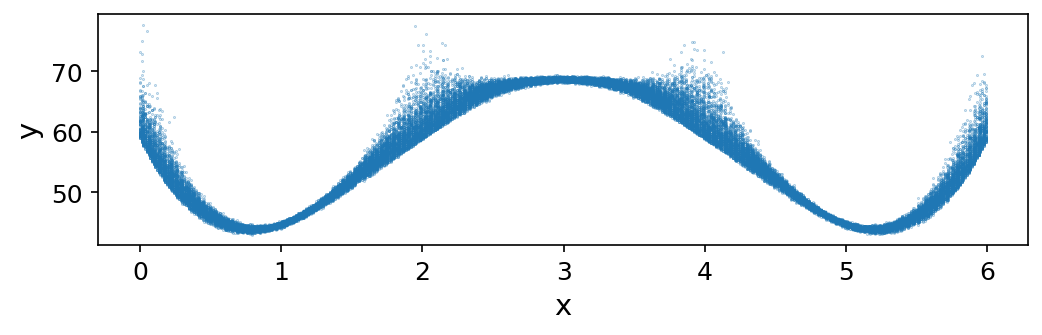

In [ ]:
# And make a scatter plot. Be sure to use a small marker size and make the dots semi-transparent!
fig, ax = plt.subplots(figsize = (8,2), dpi=150)
ax.scatter(x, y, s=0.1, alpha=0.5)
ax.set_xlabel('x')
ax.set_ylabel('y')

Imagine that you've taken this data from a physical variable you're very familiar with - and thus you know that you can model the variable with a 4th degree polynomial. Let's fit it quickly, e.g., with scikit-learn.

#### **Q2) Model the data using a 4th degree polynomial**
<details>
<summary>Tips</summary>
Scikit-learn doesn't include a polynomial regression model because they can be more easily made by extending the linear model! Since a polynomial regression is simply the linear combination of inputs to different powers, you can instead populate the feature space with these and fit a linear regression model.

See <a href="https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html">this scikit-learn module</a> for more details.

</details>

In [ ]:
# Fit a 4th degree polynomial regression model using scikit-learn
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
poly_features = PolynomialFeatures(degree=4, include_bias=False)
x_poly = poly_features.fit_transform(x.reshape(-1, 1))

lin_reg = LinearRegression()
lin_reg.fit(x_poly, y)

x_pred = np.linspace(x.min(), x.max(), 500)
x_pred_poly = poly_features.transform(x_pred.reshape(-1, 1))
y_pred = lin_reg.predict(x_pred_poly)

Text(0, 0.5, 'y')

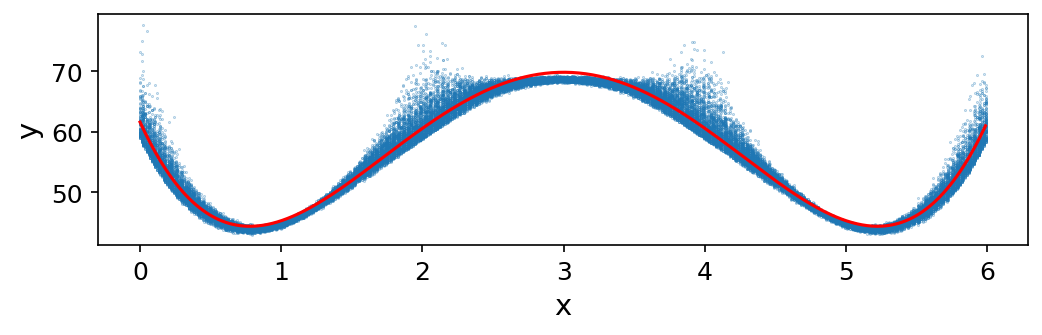

In [ ]:
# Plot the polynomial regression and the datapoints
fig, ax = plt.subplots(figsize = (8,2), dpi=150)
ax.scatter(x, y, s=0.1, alpha=0.5)
ax.plot(x_pred, y_pred, alpha=1, color='red')
ax.set_xlabel('x')
ax.set_ylabel('y')

In [ ]:
#@markdown Here's one solution for fitting the model. Double click to see the answer.
%%script false --no-raise-error
# Remove %%script false --no-raise-error in order to get this cell to run
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
poly_features = PolynomialFeatures(degree=4, include_bias=False)
x_poly = poly_features.fit_transform(x.reshape(-1, 1))

lin_reg = LinearRegression()
lin_reg.fit(x_poly, y)

x_pred = np.linspace(x.min(), x.max(), 500)
x_pred_poly = poly_features.transform(x_pred.reshape(-1, 1))
y_pred = lin_reg.predict(x_pred_poly)

In [ ]:
#@markdown Here's a quick plot of the polynomial regression in the solution above. Double click to see the answer.
%%script false --no-raise-error
# Remove %%script false --no-raise-error in order to get this cell to run
fig, ax = plt.subplots(figsize = (8,2), dpi=150)
ax.scatter(x, y, s=0.1, alpha=0.5)
ax.plot(x_pred, y_pred, alpha=1, color='red')
ax.set_xlabel('x')
ax.set_ylabel('y')

This does a pretty good job, but we can clearly see that y isn't a simple function of x - after all, there are multiple values of y for each value of x, so technically a function relating x to y does not exist!

Thus, we can say that there is a degree of uncertainty in the value we predict for y. One common way to express this in your model is to add simple error bars, which quantify how far away your predicted y is from the actual value of y - **on average**.

#### **Q3) How would express the confidence in this model?**
Imagine a stakeholder asks you for a measurement of the error and how confident you are in the model predictions.

<details>
<summary>Tips</summary>

Think of the many functions you already know for quantifying the error. Given the large number of samples that you have, how can you express the average error?

Once you have a way of quantifying the error, how can you express your confidence in the spread of the error?

</details>

In [ ]:
# Quantify the error in the predictions made by the model
error = np.abs(lin_reg.predict(x_poly) - y)
print(f'The mean absolute error is {error.mean():.2f}')
print(f'The standard deviation of the error is {error.std():.2f}')
print(f'The maximum error is {error.max():.2f}')
print(f'The variance in y is {y.std():.2f}')

The mean absolute error is 0.91
The standard deviation of the error is 1.03
The maximum error is 17.95
The variance in y is 8.94


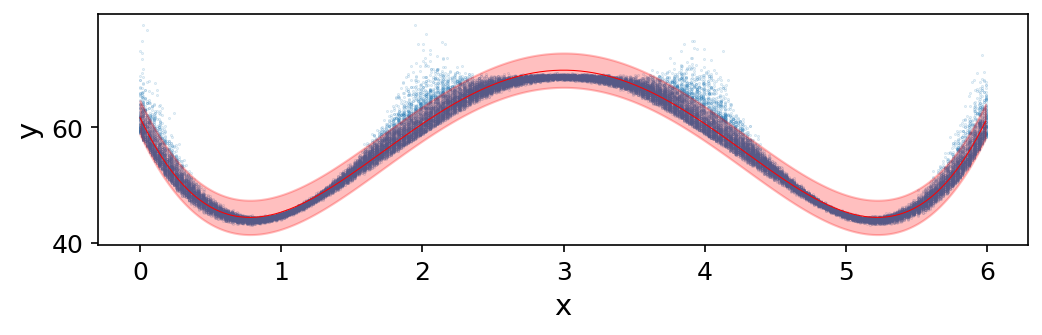

In [ ]:
# Plot the model with your confidence intervals
fig, ax = plt.subplots(figsize = (8,2), dpi=150)
ax.scatter(x, y, s=0.1, alpha=0.25)
ax.plot(x_pred, y_pred, alpha=1, color='red', linewidth=0.5)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.fill_between(x_pred, y_pred - error.mean() - 2 * error.std(), y_pred + error.mean() + 2*error.std(), alpha=0.25, color='red')

<details>
  <summary>Click here to read about one way you could answer question 1. Read it once you have your own answer 🙂 </summary>

One way that you can quantify the error is by figuring out how far away your prediction is from the truth, on average. This can be done, e.g., by calculating the *mean absolute error*, i.e. $\text{MAE} = \dfrac{1}{n}\sum_{i=0}^{n}|\hat{y}_i - y_i|$.

If you were to calculate the MAE and its statistics, as well as the variance of y, you'd get the following values (see our code cell below for the calculation)

> The mean absolute error is 0.91 <br>
The standard deviation of the error is 1.03 <br>
The maximum error is 17.95 <br>
The variance in y is 8.94

If one were to see the report of this model including this MAE, one could get the misplaced impression that the model is able to capture the data's behavior quite well - an MAE of 0.91 compared to a variance of ~9 could give the appearance that the model does well enough (and for some applications, this could indeed be true).

We can see, however, that the model does significantly worse at explaining the behavior of y around values of $x = 1$, $3$, and $5$. Similarly, by having a single value to represent the error mean and standard deviation, we are underconfident in our predictions in areas where our model does better (e.g.,  around x=2 & x=4).

Like we discussed before, there can be many sources for the uncertainty we observe- for example, the spread in the values could be due to a stochastic process (i.e., a process we can only describe statistically), and this may lead us to have models that are better suited to predict conditions around specific inputs.
</details>

In [ ]:
#@markdown Our solution for quantifying the average error.
%%script false --no-raise-error
# Remove %%script false --no-raise-error to get this cell to run
# Quantify the error using the mean absolute error.
error = np.abs(lin_reg.predict(x_poly) - y)
print(f'The mean absolute error is {error.mean():.2f}')
print(f'The standard deviation of the error is {error.std():.2f}')
print(f'The maximum error is {error.max():.2f}')
print(f'The variance in y is {y.std():.2f}')

In [ ]:
#@markdown Our solution for visualizing the error.
%%script false --no-raise-error
# Remove %%script false --no-raise-error to get this cell to run.
# Plot the polynomial model with error bars
fig, ax = plt.subplots(figsize = (8,2), dpi=150)
ax.scatter(x, y, s=0.1, alpha=0.25)
ax.plot(x_pred, y_pred, alpha=1, color='red', linewidth=0.5)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.fill_between(x_pred, y_pred - error.mean() - 2 * error.std(), y_pred + error.mean() + 2*error.std(), alpha=0.25, color='red')

You may notice that simply using the average error for all $x$ is clearly unsatisfactory as we alternate between under-estimating and over-estimating the error 😞

Looking a bit more closely 🕵 it would seem as if we need a different error bar for each $x$.

To get some intuition, let's look at the distribution of y values in our data near $x = 1.1$. Let's do this by finding all of the points that are within .02 of 1.1, and then plotting the histogram.

Text(0.5, 1.0, 'Distribution of y values for x ≈ 1.1')

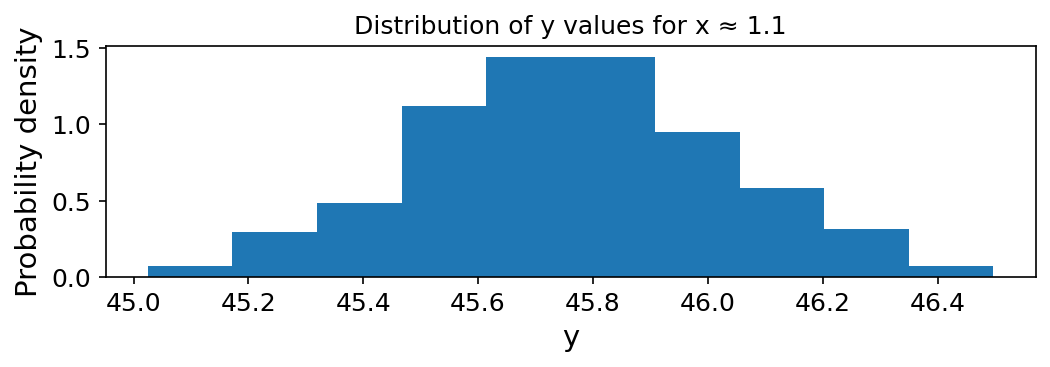

In [ ]:
# Select x values within 0.01 of 1
x_close = x[np.abs(x - 1.1) < 0.02]

# Select the corresponding y values
y_close = y[np.abs(x - 1.1) < 0.02]

# Plot the distribution of y values
fig, ax = plt.subplots(figsize = (8,2), dpi=150)
ax.hist(y_close, density=True)
ax.set_xlabel('y')
ax.set_ylabel('Probability density')
ax.set_title('Distribution of y values for x ≈ 1.1')

If you did as we did, you should get the following plot: <br><center>
<!-- <img src="https://github.com/tbeucler/2024_MLEES_Ebook/blob/main/Milton/paste_link_here.png?raw=1" width=80% height=250></center> -->

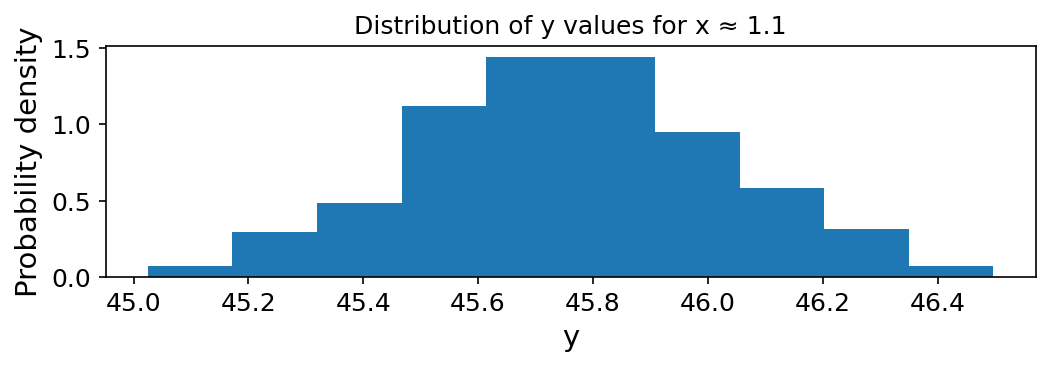

Looking at this histogram, it looks like we could make the assumption that the distribution of y given a value of x can be approximated by a normal distribution (a.k.a. a bell curve, or a gaussian).

The question now becomes, <i>how do we do this?</i> 🤔

### Distributional Regression

In [ ]:
#@markdown Run this code cell to define some functions we'll need for an interactive demo
from ipywidgets import interact
from ipywidgets import fixed
def gaussian(mean, std):
    """
    Plots a gaussian distribution with a given mean and standard deviation.

    Parameters
    ----------
    mean : float
        The mean of the gaussian distribution.
    std : float
        The standard deviation of the gaussian distribution.
    """
    plt.close('all')
    fig, ax = plt.subplots(figsize = (8,2), dpi=150)
    x = np.linspace(mean - 6*std, mean + 6*std, 500)
    y = np.exp(-0.5 * (( x - mean) / std) ** 2) / (std * np.sqrt(2 * np.pi))
    ax.plot(x, y)
    ax.set_xlabel('x')
    ax.set_ylabel('Probability Density')
    ax.set_title(f'Gaussian with mean {mean} and std {std}')
    ax.set_xlim(-30, 40)
    ax.set_ylim(0, max(y.max()*1.1, 0.5))
    plt.show()

In order to make this adjustment, we can write a model that predicts a distribution for each value of x. In this way, we are writing a model for the joint probability of x and y. As you may know, the shape of a normal distribution is given by two values: the mean (mu, $\mu$) and the standard deviation (sigma, $\sigma$).

If you run the code below, you can play around with a gaussian distribution and see how the two parameters change the output.

In [ ]:
interact(gaussian, mean=(-5, 5, 0.1), std=(0.5, 10, 0.5))

interactive(children=(FloatSlider(value=0.0, description='mean', max=5.0, min=-5.0), FloatSlider(value=5.0, de…

<function __main__.gaussian(mean, std)>

Given that we can do this, why don't we train a neural network to predict the mean (*$\mu$*) and standard deviation (*$\sigma$*) of y given a value of x? Well, if you use the techniques we've been using so far, this might seem straightforward, until you reach the following question: <br> *what should I use as a training loss?*

Before, you trained neural networks to reduce some kind of deterministic metric (e.g., the mean average error, root mean square error, or accuracy). However, these metrics require that we compare singular values against other singular values - if we predict $\mu$ and $\sigma$, we will need a function that will return a singular value when comparing distributions.

Here is where the Continuous Ranked Probability Score (CRPS) comes in! Let's walk through what we're going to do in order for us to understand how our network will learn.

### Explaining CRPS

The CRPS is a value that quantifies the absolute area between the <a href="https://en.wikipedia.org/wiki/Cumulative_distribution_function"> cumulative distribution function</a> of two distributions. Let's say that we have two gaussians we want to compare to the standard gaussian distribution ($\mu = 0$ and $\sigma = 1$), the first with $\mu = 0.5$ and $\sigma = 1.2$, and the second with $\mu=0.1$ and $\sigma = 1.7$. Which of these two is closer to the standard gaussian?

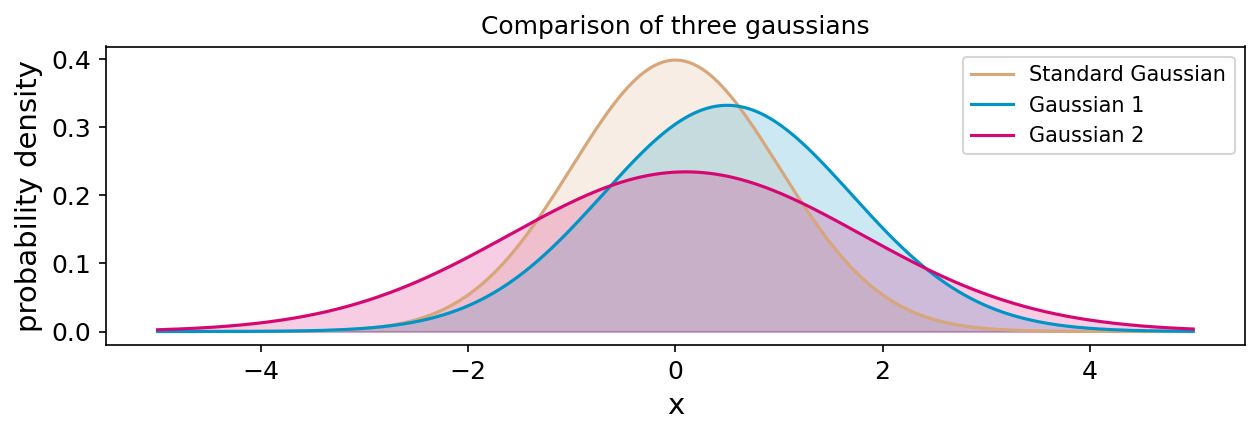

In [ ]:
#@markdown Let's plot the three gaussians. As always, feel free to check the code by double clicking :)
from scipy.stats import norm
fig, ax = plt.subplots(figsize = (8.5,3), dpi=150)
x = np.linspace(-5, 5, 500)
y1 = norm(0, 1).pdf(x)
y2 = norm(0.5, 1.2).pdf(x)
y3 = norm(0.1, 1.7).pdf(x)

colors = [np.array([215, 166, 122])/255, np.array([0, 148, 199])/255, np.array([214, 7, 114])/255]
labels = ['Standard Gaussian', 'Gaussian 1', 'Gaussian 2']

for i, y in enumerate([y1, y2, y3]):
    ax.plot(x, y, color=colors[i], label=labels[i])
    # shade the area underneath the curve
    ax.fill_between(x, 0, y, color=colors[i], alpha=0.2)

ax.set_xlabel('x')
ax.set_ylabel('probability density')
ax.set_title('Comparison of three gaussians')
ax.legend()
fig.tight_layout();

Like we said, the CRPS depends on the area between the CDFs. Let's plot the CDFs of the standard Gaussian with the two Gaussians. Calculating the CRPS between two Gaussians requires a bit of math that we don't want to get into, so we'll just give you the function to calculate it 😀

In [ ]:
#@markdown This cells defines the gaussian_crps function, which takes in $\mu_1,\; \sigma_1,\; \mu_2,\; \sigma_2$
from scipy.stats import norm
def gaussians_crps(mu_F, sigma_F, mu_G, sigma_G):
    """
    Calculates the CRPS between two gaussians.

    Parameters
    ----------
    mu_F : float
        The mean of the first gaussian.
    sigma_F : float
        The standard deviation of the first gaussian.
    mu_G : float
        The mean of the second gaussian.
    sigma_G : float
        The standard deviation of the second gaussian.

    Returns
    -------
    crps : float
        The CRPS between the two gaussians.
    """
    # Calculate the intersection
    x_inter = (mu_F * sigma_G - mu_G * sigma_F) / (sigma_G - sigma_F)


    min_bound = min(mu_F - 4 * sigma_F, mu_G - 4 * sigma_G)
    max_bound = max(mu_F + 4 * sigma_F, mu_G + 4 * sigma_G)

    first_area = None
    if x_inter > min_bound:
        x_lower = np.linspace(min_bound, x_inter, 100)
        # Calculate the CDF values for x_lower
        y_lower_F = norm(mu_F, sigma_F).cdf(x_lower)
        y_lower_G = norm(mu_G, sigma_G).cdf(x_lower)

        # Calculate the area under the curve
        first_area = np.abs(np.trapz(y_lower_F, x_lower) - np.trapz(y_lower_G, x_lower))

    second_area = None
    if x_inter < max_bound:
        x_upper = np.linspace(x_inter, max_bound, 100)
        # Calculate the CDF values for x_upper
        y_upper_F = norm(mu_F, sigma_F).cdf(x_upper)
        y_upper_G = norm(mu_G, sigma_G).cdf(x_upper)
        # Calculate the area under the curve
        second_area = np.abs(np.trapz(y_upper_F, x_upper) - np.trapz(y_upper_G, x_upper))

    # Calculate the CRPS
    crps = (first_area if first_area is not None else 0) + (second_area if second_area is not None else 0)

    return crps

In [ ]:
#@markdown Run this cell to get an interactive plot visualizing the two distributions, the area between them, and the resulting CRPS.
def compare_gaussians(mu_1=0.5, sigma_1=1.2, mu_2=0.1, sigma_2=1.7):
    """
    Compares two gaussians.

    Parameters
    ----------
    mu_1 : float
        The mean of the first gaussian.
    sigma_1 : float
        The standard deviation of the first gaussian.
    mu_2 : float
        The mean of the second gaussian.
    sigma_2 : float
        The standard deviation of the second gaussian.
    """
    plt.close('all')

    fig, axs = plt.subplots(2, 1, figsize = (6,5), dpi=100, sharex=True)

    fig.set_facecolor(np.array([64,64,62])/255)
    standard_gaussian = norm(0, 1)

    x_lower = min(mu_1 - 4 * sigma_1, mu_2 - 4 * sigma_2)
    x_upper = max(mu_1 + 4 * sigma_1, mu_2 + 4 * sigma_2)
    x = np.linspace(x_lower, x_upper, 500)
    ys = []
    ys.append(standard_gaussian.cdf(x))
    ys.append(norm(mu_1, sigma_1).cdf(x))
    ys.append(norm(mu_2, sigma_2).cdf(x))

    crps_scores = []
    crps_scores.append(gaussians_crps(0, 1, mu_1, sigma_1))
    crps_scores.append(gaussians_crps(0, 1, mu_2, sigma_2))

    for idx, ax in enumerate(axs):
        ax.plot(x, ys[0], color = colors[0], label=labels[0])
        ax.plot(x, ys[idx+1], color=colors[idx+1], label=labels[idx+1], linewidth=0.1)
        legend = ax.legend()



        ax.fill_between(x, ys[0], ys[idx+1], color=colors[idx+1], alpha=0.2)
        ax.set_title(f'Gaussian {idx+1} CRPS {crps_scores[idx]:.2f}')
        ax.set_ylabel('Cumulative Prob.')
        ax.set_ylim(-0.05, 1.05)

        # Change the legend facecolor
        legend.get_frame().set_facecolor(np.array([217, 217, 217])/255)
        # And make the legend lines more visibile
        for line in legend.get_lines():
            line.set_linewidth(2)

        # set the labels, ticks, tickmarks, axis labels, and title colors to white):
        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                    ax.get_xticklabels() + ax.get_yticklabels()):
            item.set_color('white')
        ax.tick_params(axis='both', which='both', color='white')

        # draw axis lines
        xaxis = ax.axhline(y=0, color='k', linestyle='--', linewidth=0.3)
        yaxis = ax.axvline(x=0, color='k', linestyle='--', linewidth=0.3)

        xaxis.set_dashes([20, 10])
        yaxis.set_dashes([20, 10])

    axs[1].set_xlabel('x')
    fig.tight_layout()
    plt.show()

compare_gaussians.__doc__ = None

interact(compare_gaussians,
         mu_1=(-1, 1, 0.1), sigma_1=(1.1, 3, 0.1), # Parameter range of distribution 1
         mu_2=(-1, 1, 0.1), sigma_2=(1.1, 3, 0.1), # Parameter range of distribution 2
         )

interactive(children=(FloatSlider(value=0.5, description='mu_1', max=1.0, min=-1.0), FloatSlider(value=1.2, de…

<function __main__.compare_gaussians(mu_1=0.5, sigma_1=1.2, mu_2=0.1, sigma_2=1.7)>



We now have a way to evaluate the distance between two distributions (and it's even a [*proper score*](https://en.wikipedia.org/wiki/Scoring_rule#:~:text=Any%20given%20proper%20scoring%20rule,the%20predicted%20probabilities%20will%20ultimately) !!!) - but if you recall what we're going to be doing is comparing the gaussian that we predict to deterministic observations (i.e., we'll predict a distribution but our target is a single value).

How do we go about doing this? Well, one way that we can do this is to represent our observations with what is known as a <a href='https://en.wikipedia.org/wiki/Degenerate_distribution'>*degenerate distribution*</a> (a.k.a. a dirac distribution), whose PDF is a step function with a value between 0 and 1, where the change happens at the value of our observation. Let's make a quick plot, since a picture is worth 1000 words!
📸


In [ ]:
#@markdown Run this cell to get an interactive plot of a degenerate distribution.
def degenerate_distribution(x):
    """
    Plots a degenerate distribution.

    Parameters
    ----------
    x : float
        The value of the degenerate distribution.
        """
    plt.close('all')
    fig, ax = plt.subplots(figsize = (8,2), dpi=150)

    x_range = np.linspace(x - 5, x + 5, 500)
    Y_heaviside = np.heaviside(x_range - x, 0)
    ax.plot(x_range, Y_heaviside, color=np.array([215, 166, 122])/255)

    ax.set_xlabel('x')
    ax.set_ylabel('Cumulative Prob.')
    ax.set_title(f'Degenerate distribution with x = {x}')
    ax.set_xlim(x-5, x+5)
    ax.set_ylim(-.05, 1.05)
    ax.axhline(y=0, color='k', linestyle='--', linewidth=0.3)
    ax.axvline(x=0, color='k', linestyle='--', linewidth=0.3)
    plt.show()

interact(degenerate_distribution, x=(-4.9, 4.9, 0.1))

interactive(children=(FloatSlider(value=0.0, description='x', max=4.9, min=-4.9), Output()), _dom_classes=('wi…

<function __main__.degenerate_distribution(x)>

With this, we have two distributions that we can compare using the CRPS! Let's take a single value of x in our dataset, and see if we can manually minimize the CRPS value for the observations for that single value of X.

In [ ]:
# Let's load the files again. Note that they're npy files
y = np.load(y_file)
x = np.load(x_file)

# 1.02 is one of the unique values in x, so let's use it
# to get a sample of y_values.
sample_x = 1.02

# Let's get the corresponding y values
sample_y = y[x == sample_x]

# Print out some statistics
mean = sample_y.mean()
std = sample_y.std()
print(f'There are {len(sample_y)} y values for x = {sample_x}')
print(f'The mean of the sample is {mean:.2f} and the standard deviation is {std:.2f}')

# and 5 points
sample_y = np.random.choice(sample_y, 5)

There are 98 y values for x = 1.02
The mean of the sample is 44.87 and the standard deviation is 0.24


In [ ]:
# Code based on the properscoring library
# https://github.com/properscoring/properscoring/
def crps_gaussian(y, mu, sig):
    """
    Computes the CRPS of observations y relative to normally distributed
    forecast with mean, mu, and standard deviation, sig.

    CRPS(N(mu, sig^2); x)

    Formula taken from Equation (5):

    Calibrated Probablistic Forecasting Using Ensemble Model Output
    Statistics and Minimum CRPS Estimation. Gneiting, Raftery,
    Westveld, Goldman. Monthly Weather Review 2004

    http://journals.ametsoc.org/doi/pdf/10.1175/MWR2904.1

    Parameters
    ----------
    x : scalar or np.ndarray
        The observation or set of observations.
    mu : scalar or np.ndarray
        The mean of the forecast normal distribution
    sig : scalar or np.ndarray
        The standard deviation of the forecast distribution
    grad : boolean
        If True the gradient of the CRPS w.r.t. mu and sig
        is returned along with the CRPS.

    Returns
    -------
    crps : scalar or np.ndarray or tuple of
        The CRPS of each observation y relative to mu and sig.

    """
    y = np.asarray(y)
    mu = mu
    sig = sig

    # Normalize the y values using mu and sigma
    y_norm = (y - mu) / sig

    # Generate the standard gaussian
    std_distribution = norm(0, 1)

    # Calculate the pdf and cdf function values at which the target y value
    # is located, as well as the constant value we'll need
    pdf = std_distribution.pdf(y_norm)
    cdf = std_distribution.cdf(y_norm)
    c = 1. / np.sqrt(np.pi)

    # Calculate the crps using the analytical formula from the reference
    crps = sig * (y_norm * (2 * cdf - 1) + 2 * pdf - c)

    return crps

In [ ]:
def degenerate_gaussian(obs, mu = mean-1, sigma = std-.2):
    """
    Plots a degenerate distribution cdf of a set of observations alongside a gaussian distribution cdf. Also outputs the CRPS value for each observation, as well as the mean CRPS value.

    Parameters
    ----------
    obs : np.ndarray
        The observations.
    mu : float
        The mean of the gaussian distribution.
    sigma : float
        The standard deviation of the gaussian distribution.
    """
    lower_bound = min(mu - 3 * sigma, np.min(obs).item() - 3 * sigma)
    upper_bound = max(mu + 3 * sigma, np.max(obs).item() + 3 * sigma)

    norm_distribution = norm(mu, sigma)
    obs_range = np.linspace(lower_bound, upper_bound, 500)

    cdf = norm_distribution.cdf(obs_range)

    crps_vals = np.zeros(len(obs))
    for idx, obs_val in enumerate(obs):
        crps_vals[idx] = crps_gaussian(y=obs_val, mu=mu, sig=sigma)

    num_rows = len(obs)
    fig, axs = plt.subplots(num_rows, 1, figsize = (6,8), dpi=100, sharey=True)
    fig.set_facecolor(np.array([64,64,62])/255)
    for idx, ax in enumerate(axs):
        degenerate_distribution = np.heaviside(obs_range - obs[idx], 0)
        ax.plot(obs_range, cdf, color=colors[0])
        ax.plot(obs_range, degenerate_distribution, color=np.array([0, 148, 199])/255)

        ax.fill_between(obs_range, cdf, degenerate_distribution, color=colors[0], alpha=0.2)

        # add label on the right side
        # Add a label on the right border
        label = f'CRPS: {crps_vals[idx]:.2f}'
        ax.annotate(label, xy=(1, 0.5), xycoords='axes fraction',
            xytext=(10, 0), textcoords='offset points',
            ha='left', va='center', rotation=90, color='white')

        # set the labels, ticks, tickmarks, axis labels, and title colors to white):
        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                    ax.get_xticklabels() + ax.get_yticklabels()):
            item.set_color('white')
        ax.tick_params(axis='both', which='both', color='white')

    fig.suptitle(f'Distribution with mean {mu:.2f} and std {sigma:.2f}\nMean CRPS: {crps_vals.mean():.2f}', color='white')
    fig.tight_layout()
    plt.show()

# Remove the docstring for a better user experience with interact()
degenerate_gaussian.__doc__ = None


In [ ]:
#@markdown This cell will let you do what you will train your network to do! Can you find the mu and sigma that will minimize the value of the crps for these 5 observations?
mu_min = sample_y.min()
mu_max = sample_y.max()
sigma_min = sample_y.std() / 6
sigma_max = sample_y.std() * 6

interact(degenerate_gaussian, mu=(mu_min, mu_max, 0.1), sigma=(sigma_min, sigma_max, 0.1), obs=fixed(sample_y))

interactive(children=(FloatSlider(value=44.31597513575244, description='mu', max=45.251470019248146, min=44.31…

<function __main__.degenerate_gaussian(obs, mu=43.86809334841716, sigma=0.044339984482627104)>

### Setting up the Neural Network

Today, we'll be modeling the conditional uncertainty by setting up a simple neural network using PyTorch.

In [ ]:
# Let's start by importing torch, the functional api, and the module api
import torch
import torch.nn.functional as F
from torch import nn

#### **Q4) Set up a simple neural network using PyTorch**

In [ ]:
# Set up a simple neural network by defining a class that inherits from nn.module. Replace ___ with whatever you want to name your class
class zbr(nn.Module):
    # Let's define what our model will look like using the init method
    def __init__(self,input_size, hidden_size, output_size
                # Add additional arguments depending on what you need to define your neural network. We recommend have at least:
                # the input size (i.e., the number of features in the input)
                # the number of neurons in each hidden layer
                # the output size (i.e., the number of features in the output)
                ):
        # Call the parent's __init__ method. Replace ___ with the name of your class
        super(zbr, self).__init__()

        # Here is how you define a linear layer (i.e., a layer that combines n number of inputs linearly into m number of outputs). The values for n and m will likely depend on your arguments, or you can hard code them into your model definition if you prefer.
        self.fc1 = nn.Linear(input_size, hidden_size)

        #You can also add as many layers as you like. Also, don't worry about the activation functions for now - we'll define them further down.
        self.fc2 = nn.Linear(hidden_size, input_size)
    # When the model is trained or used in inference, it calls upon its 'forward' method, which tell's it precisely what it needs to do. Let's go ahead and define it
    def forward(self,
                x, # Note that x is whatever inputs the neural network sees
                ):
        # The convention is to overwrite x whenever we call upon the model's layers. Let's assume you have a fully connected layer called fc1. This is how you would apply the leaky relu activation function:
        #x = F.leaky_relu(self.fc1(x))

        # Write out your actual model below.
        x = F.leaky_relu(self.fc1(x))
        x = self.fc2(x)
        # and finally, you should return the final value for x
        return x

In [ ]:
#@markdown Our solution for defining a simple model
%%script false --no-raise-error
# Remove %%script false --no-raise-error to get this cell to run.
# Now, let's create a model by defining a class that inherits from nn.module
class ANN(nn.Module):
    # Let's define what our model will look like using the init method
    def __init__(self,
                 input_size, # the number of features in the input
                 hidden_size, # the number of neurons in the hidden layer
                 output_size # the number of output features.
                 ):
        super(ANN, self).__init__()

        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    # When the model is trained or used in inference, it calls upon its 'forward' method, which tell's it precisely what it needs to do. Let's go ahead and define it
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [ ]:
#@markdown CRPS isn't predefined as a loss function in torch, but it *can* be written using torch. We've gone ahead and set it up as ```CRPS_ML``` for you in this cell,

def CRPS_ML(y_pred, y_true, **kwargs):
    """Compute the Continuous Ranked Probability Score (CRPS).

    The CRPS is a probabilistic metric that evaluates the accuracy of a
    probabilistic forecast. It is defined as the integral of the squared
    difference between the cumulative distribution function (CDF) of the
    forecast and the CDF of the observations.

    Parameters
    ----------

    y_pred : array-like of shape (n_samples, 2*n_features)
        The predicted probability parameters for each sample. The odd columns
        should contain the mean (mu), and the even columns should contain the
        standard deviation (sigma).

    y_true : array-like of shape (n_samples,n_features)

    Returns
    -------
    crps : float or array-like
        The CRPS value mean, or array of individual CRPS values.

    """
    # adapted from https://github.com/WillyChap/ARML_Probabilistic/blob/main/Coastal_Points/Testing_and_Utility_Notebooks/CRPS_Verify.ipynb
    # and work by Louis Poulain--Auzeau (https://github.com/louisPoulain)
    reduction = kwargs.get("reduction", "mean")
    mu = y_pred[:, ::2]
    sigma = y_pred[:, 1::2]

    # prevent negative sigmas
    sigma = torch.sqrt(sigma.pow(2))
    loc = (y_true - mu) / sigma
    pdf = torch.exp(-0.5 * loc.pow(2)) / torch.sqrt(
        2 * torch.from_numpy(np.array(np.pi))
    )
    cdf = 0.5 * (1.0 + torch.erf(loc / torch.sqrt(torch.tensor(2.0))))

    # compute CRPS for each (input, truth) pair
    crps = sigma * (
        loc * (2.0 * cdf - 1.0)
        + 2.0 * pdf
        - 1.0 / torch.from_numpy(np.array(np.sqrt(np.pi)))
    )

    return crps.mean() if reduction == "mean" else crps

We need to define the other aspcets for our model training in torch as well. This includes the batch size, optimizer, & loss function. Let's make a list of the things we need to do:

1. Since we know the underlying relationship is well represented using 4th degree polynomials, let's make polynomial features of the x array
2. Convert the numpy arrays to pytorch tensors.
3. Convert the tensors into a tensor dataset and use the dataset to make a dataloader.
4. Instantiate the model. Remember that the model you defined above may need a number of arguments in order to be instantiated, depending on how you defined it.
5. Define the loss function and optimizer
6. Write and run the training loop. It should include an early stopping criterion or two :


#### **Q5) Implement steps 1-5 detailed above in the code cells below.**

In [ ]:
# Make the polynomial features using sklearn's PolynomialFeatures. Remember to make sure that the shape of the data you transform is (num_samples, num_features) - otherwise sklearn will complain.
poly_fitter = PolynomialFeatures(degree=4, include_bias=False)

In [ ]:
# Transform the numpy arrays into pytorch tensors.
poly_x = poly_fitter.fit_transform(x.reshape(-1, 1))

In [ ]:
# Use the x and y tensors to make a torch TensorDataset
x_tensor = torch.from_numpy(poly_x).float()
y_tensor = torch.from_numpy(y[:,None]).float()
print(x_tensor.shape, y_tensor.shape)

torch.Size([50000, 4]) torch.Size([50000, 1])


In [ ]:
# Use your tensor dataset to make a torch DataLoader

dataset = torch.utils.data.TensorDataset(x_tensor, y_tensor)
dataloader = torch.utils.data.DataLoader(dataset,
                                         batch_size=256, # The number of samples in each batch
                                         shuffle=True, # Whether to shuffle the order of the points being fed during training
                                         )

In [ ]:
#@markdown Here is our solution to the above segments.
%%script false --no-raise-error
# Remove %%script false --no-raise-error to get this cell to run.
poly_fitter = PolynomialFeatures(degree=4, include_bias=False)
poly_x = poly_fitter.fit_transform(x.reshape(-1, 1))

x_tensor = torch.from_numpy(poly_x).float()
y_tensor = torch.from_numpy(y[:,None]).float()
print(x_tensor.shape, y_tensor.shape)

dataset = torch.utils.data.TensorDataset(x_tensor, y_tensor)
dataloader = torch.utils.data.DataLoader(dataset,
                                         batch_size=256, # The number of samples in each batch
                                         shuffle=True, # Whether to shuffle the order of the points being fed during training
                                         )

In [ ]:
# Instantiate your model in this cell
model = zbr(4, #Number of input features
            110, # Number of neurons / hidden layer
            2 # Predicted features, =2 because we predict a mean and std
            )

In [ ]:
# Define your loss function - in this case, we'll use CRPS
loss_function = CRPS_ML

In [ ]:
# And define your optimizer. You could start with Adam, but choose whatever suits your fancy.
optimizer = torch.optim.NAdam(model.parameters(), lr=0.0001)

In [ ]:
#@markdown Our solution for the above segments is here
%%script false --no-raise-error
# Remove %%script false --no-raise-error to get this cell to run.

model = ANN(4, #Number of input features
            110, # Number of neurons / hidden layer
            2, # Predicted features, =2 because we predict a mean and std
            )

loss_function = CRPS_ML
optimizer = torch.optim.NAdam(model.parameters(), lr=0.0001)

#### **Q6) Update the training loop as needed, and train a model.**

In [ ]:
# training loop
num_epochs = 100
losses = []
print('Starting training')
for epoch in range(num_epochs):
    batch_losses = []
    i = 0
    for x_batch, y_batch in dataloader:
        i+=1
        print(f'\rEpoch {epoch+1}/{num_epochs}, Batch {i}/{len(dataloader)}, last loss: {losses[-1] if len(losses)>=1 else 0}', end='', flush=True)

        # Reset the gradients - needs to happen for each iteration
        optimizer.zero_grad()
        # Forward pass
        y_pred = model(x_batch)
        # Compute the loss
        loss = loss_function(y_pred, y_batch)
        batch_losses.append(loss.item())

        # Backpropagation
        loss.backward()
        # Update the weights
        optimizer.step()
    losses.append(np.mean(batch_losses))

    # save the best model
    if len(losses) > 1:
        if losses[-1] < min(losses[:-1]):
            torch.save(model.state_dict(), 'best_model.pth')

    # early stopping
    if len(losses) >=10:
        if np.mean(losses[-10:]) < losses[-1]:
            break

print('\n Training complete')

Starting training
Epoch 100/100, Batch 196/196, last loss: 1.0553838613690163
 Training complete


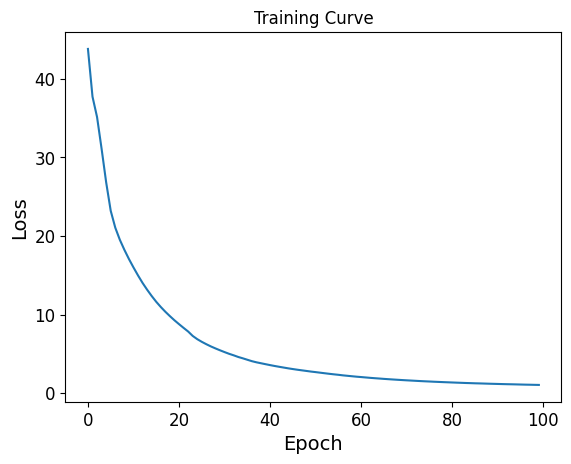

In [ ]:
# Plot the training curve
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Curve')
plt.show()

### Model Performance Overview

In [ ]:
# Let's go ahead and load the best model state from what we saved before
model.load_state_dict(torch.load('best_model.pth'))

<ipython-input-87-dbcff48ba996>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


<All keys matched successfully>

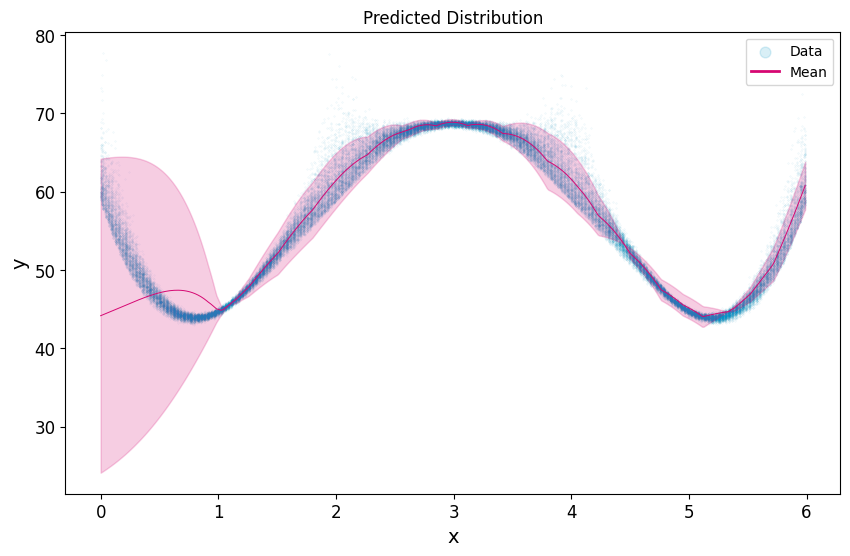

In [ ]:
# Let's go ahead and generate the plot for our predicted distributions
x_plot = np.linspace(x.min(), x.max(), 500)
x_plot = poly_fitter.fit_transform(x_plot[:,None])

x_tensor_plot = torch.from_numpy(x_plot).float()
y_pred = model(x_tensor_plot)

mu = y_pred[:, 0].detach().numpy()
sigma = np.abs(y_pred[:, 1].detach().numpy())

plt.figure(figsize=(10, 6))
plt.scatter(x, y, label='Data', alpha=0.15, s=0.05, color = colors[1])

#plot the mean
plt.plot(x_plot[:,0], mu, label='Mean', color=colors[2], linewidth=0.7)

# plot 2 standard deviations above and below
plt.fill_between(x_plot[:,0], mu + 2*sigma, mu - 2*sigma, color=colors[2], alpha=0.2)

plt.xlabel('x')
plt.ylabel('y')
plt.title('Predicted Distribution')
# Increase the weight of the lines in the legend
legend = plt.legend()
for line in legend.get_lines():
    line.set_linewidth(2)
# increase the marker size of the scatter elements in the legend
legend.legend_handles[0]._sizes = [60];

plt.show()

### Model Evaluation

Now that we have a probabilistic model, we need to discuss ways in which to evaluate how well our model performs. However, up to now we've focused on deterministic metrics (e.g., RMSE, accuracy, MAE) in order to evaluate the performance of our models. As we saw before, these metrics are less useful when we predict a whole distribution as our outputs (whether it be via distributional regression as we did above, or even when making predictions with ensembles).

Furthermore, we used the one probabilistic metric we've discussed as our optimization target (i.e., we trained the model to minimize the CRPS) -  if we use it as an evaluation metric we'll get an overly optimistic view of how well our model performs. We're therefore going to introduce two more metrics to evaluate the performance of our model.

Note that these metrics also work when using other methods for quantifying uncertainty, such as cross-validation or model ensembles. However, the scores will be much worse for models whose errors aren't conditional on the inputs!

#### Spread Skill Score
The Spread Skill Score (SSC) is used to quantify how large the *spread* predicted by your model(s) is (e.g., the predicted sigma in our case) compared to the mean error associated with predicted mean (i.e., its *skill*).

In [ ]:
# let's start by calculating the unique values of X. Note that normally this would done, e.g., by carrying out a random selection of inputs in order to sample the predicted spread and error. However, here we have the luxury of knowing that we have a relatively range of unique values for our univariate input.
unique_x = np.unique(x)

spread = np.zeros_like(unique_x)
error = np.zeros_like(unique_x)
# For each unique X value, let's get the predicted spread and the MAE
for idx, x_val in enumerate(unique_x):
    # Get the corresponding y values
    y_true = y[x==x_val]

    # Generate the mean and std from the model
    mu, sigma = model(torch.from_numpy(poly_fitter.fit_transform(np.asarray(x_val)[None,None])).float()).detach().numpy().squeeze()

    # Make sure that sigma is always positive
    sigma = np.sqrt(sigma**2)

    # Calculate the spread and error
    spread[idx] = sigma
    error[idx] = np.abs((y_true - mu)).mean() # MAE

# Sort the spread and error by increasing error
idxs = np.argsort(error)
error = error[idxs]
spread = spread[idxs]

ValueError: too many values to unpack (expected 2)

<ipython-input-73-f348f9b27324>:6: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(0, upper_bound)
<ipython-input-73-f348f9b27324>:7: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(0, upper_bound)


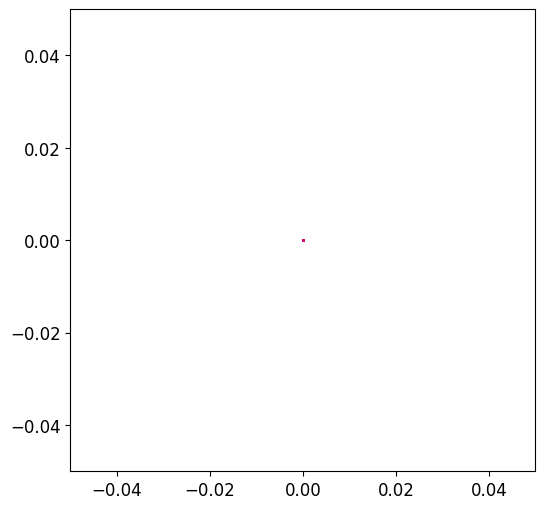

In [ ]:
# Make a square figure using plt.subplots
fig, ax = plt.subplots(figsize=(6, 6), dpi=100)

# set the origin to 0,0 and the top right corner to max(error_max, spread_max)
upper_bound = max(error.max(), spread.max()) * 1.1
ax.set_xlim(0, upper_bound)
ax.set_ylim(0, upper_bound)

# draw the diagonal line
ax.plot([0, upper_bound],
        [0, upper_bound],
        color='black',
        linestyle='--')

# plot the spread vs skill
ax.scatter(error, spread, s=0.75, color=colors[2])

Note that the ideal spread skill score is a line where the error in your prediction is equal to the spread that you predict!

Additionally, if you use a method of uncertainty quantification that isn't conditional on the inputs (like the error bars we produced way up in Question 2), you'll have a vertical line whose intersection with the diagonal will be whereever your error is as large as the spread in the data!

#### Probability Integral Transform (PIT) Histogram
While this visualization carries a name that some may find intimidating (one of your T.A.'s will readily admit to waking from a nightmare muttering something about it with a far off look on his face), it's simply a way of quantifying how well calibrated your models are. It's simply a matter of calculating the CDF of random samples from the observations and plotting a histogram.

In [ ]:
from scipy.stats import norm

# First, we need to generate a set of y values to get a global distribution of y-values.
x_vals = np.linspace(x.min(), x.max(), 500)

y_samples = []
for x_val in x_vals:
    # Let's generate mu and sigma
    mu, sigma = model(torch.from_numpy(poly_fitter.fit_transform(np.asarray(x_val)[None,None])).float()).detach().numpy().squeeze()
    # Make sure that sigma is always positive
    sigma = np.sqrt(sigma**2)

    # make the distribution using scipy and get 100 samples
    y_samples.append(norm(mu, sigma).rvs(100))

y_samples = np.concatenate(y_samples)

ValueError: too many values to unpack (expected 2)

In [ ]:
# Now that we have the predicted values for y, let's go ahead and get an estimation of the CDF of y. To do this, we'll generate a regularly spaced grid of y values going from the minimum (where CDF~0) to the maximum (where CDF~1).
from scipy.interpolate import interp1d

y_grid = np.linspace(y.min(), y.max(), 500)
cdf_grid = np.zeros_like(y_grid)
for idx, y_val in enumerate(y_grid):
    cdf_grid[idx] = np.mean(y_samples <= y_val)

# and then we make an interpolator
cdf_interpolator = interp1d(y_grid,
                            cdf_grid,
                            kind='linear',
                            )

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_axes.py:6762: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_axes.py:6763: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


ValueError: autodetected range of [nan, nan] is not finite

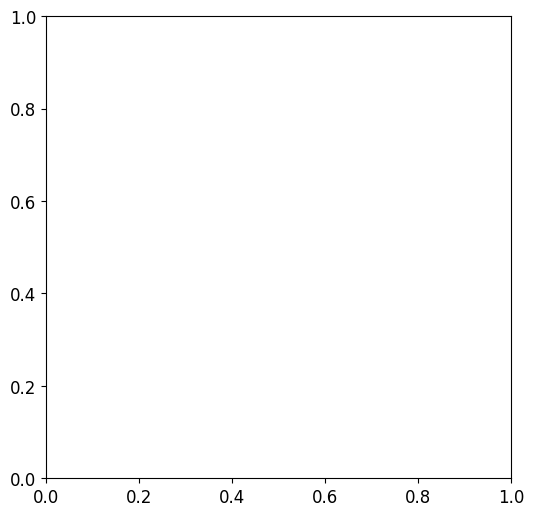

In [ ]:
# In order to make the PIT histogram, all we have to do is get a large number of samples, and plot the PDF of the CDF values calculated from the y_true samples.
# If we obtain a relatively uniform PDF, it means that our predictions do a good job of matching the CDF of the observations.

rn_gen = np.random.default_rng(seed=42)

samples = rn_gen.choice(y, size=8000)
CDF_vals = cdf_interpolator(samples)

fig, ax = plt.subplots(figsize=(6, 6), dpi=100)

nbins = 10
# Plot the histogram of the CDF values using 10 bins
ax.hist(CDF_vals, bins=nbins, density=True, color=colors[1], label='PIT Histogram')
# set the x-axis ticks to be every 0.05 between 0 and 1
ax.set_xticks(np.arange(0.05, 1.1, 0.1))
# plot the hline at 1
ax.axhline(1, color='black', linestyle='--', label='Uniform PDF')
ax.set_xlim(0, CDF_vals.max())
ax.legend()

#### **Q7) Is the model over-dispersive or under-dispersive?**

Write your thoughts here 📉

### Bonus Challenge

As you can imagine, the data that you used today does *not*, in fact, associate a gaussian distribution of values for each value of x. Instead, the distribution is a *weibull* distribution whose shape and scale parameters depend on x!

We've gone ahead and prepared an interactive demo for you to get familiar with the weibull distribution.

In [ ]:
def weibull(shape, scale):
    plt.close('all')
    fig, ax = plt.subplots(figsize = (8,2), dpi=150)
    x = np.linspace(1e-5, 100, 500)
    y = (shape / scale) * (x / scale) ** (shape - 1) * np.exp(-(x / scale) ** shape)
    ax.plot(x, y)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(f'Weibull with shape {shape} and scale {scale}')
    ax.set_xlim(0, 40)
    ax.set_ylim(0, max(y.max()*1.1, 0.5))
    plt.show()

interact(weibull, shape=(1e-5, 10, 0.1), scale=(0.5, 10, 0.5))

The challenge, however, is to repeat the fitting of the neural network by predicting a weibull instead of a gaussian distribution. Note that this means that **the CRPS we implemented above is not correct for use with the weibull distribution** - and as your TA ran out of time and energy to figure it out for you, it's up to you to figure it out.

"You really shouldn't spend too much time on this. I'd rather you work on your final project, or have a coffee" - that same TA.

In [ ]:
# You may ignore your TA and implement a CRPS loss tailored to the Weibull distribution below

In [ ]:
# Train your model with the new CRPS loss

In [ ]:
# Plot its predictions as a function of x

In [ ]:
# What does its spread skill score look like? Does the spread match the error?

In [ ]:
# What does the PIT look like? Is the model over-dispersive, under-dispersive, or just right?